In [17]:
# Cell 1 - imports & basic settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
print("TF:", tf.__version__)


TF: 2.19.0


In [18]:
# Cell 2 - load + cleanup
fn = "brisbane_water_quality.csv"   # Q1 confirmed
df = pd.read_csv(fn)
# Remove quality columns (those containing '[quality]')
cols_to_drop = [c for c in df.columns if '[quality]' in c]
df = df.drop(columns=cols_to_drop, errors='ignore')

# Parse timestamp and sort
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

# Set index and resample to uniform 30-minute grid; interpolate
df = df.set_index('Timestamp')
df = df.resample('30min').mean().interpolate()

print("Loaded shape:", df.shape)
print("Columns used:", list(df.columns))
df.head(3)


Loaded shape: (15717, 11)
Columns used: ['Record number', 'Average Water Speed', 'Average Water Direction', 'Chlorophyll', 'Temperature', 'Dissolved Oxygen', 'Dissolved Oxygen (%Saturation)', 'pH', 'Salinity', 'Specific Conductance', 'Turbidity']


,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
Timestamp,,,,,,,,,,,
2023-08-04 23:00:00,1470.750000,2.771750,143.78675,1.70275,19.959750,7.440250,100.644250,8.169,35.221250,53.270500,2.041500
2023-08-04 23:30:00,1471.333333,3.308667,176.67400,1.94100,19.932667,7.436333,100.545333,8.168,35.226333,53.277333,1.972333
2023-08-05 00:00:00,1475.000000,9.138000,52.00500,1.44300,19.822000,7.459000,100.667000,8.159,35.271000,53.337000,2.033000


Available features: ['Average Water Speed', 'Average Water Direction', 'Chlorophyll', 'Temperature', 'pH', 'Salinity', 'Specific Conductance', 'Turbidity']
Target: Dissolved Oxygen


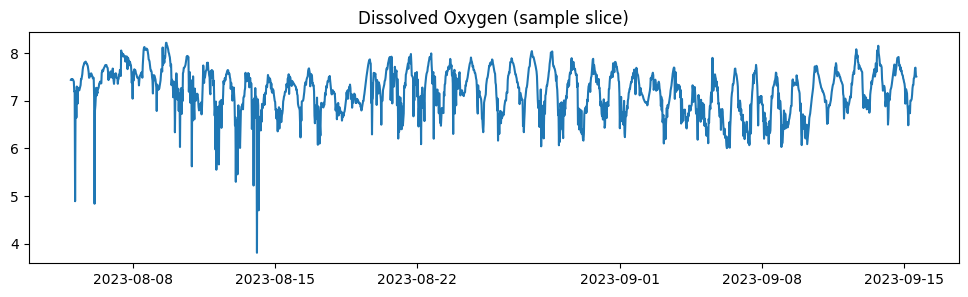

In [19]:
# Cell 3 - feature selection & sample plot
# Core features (we'll only use ones that exist in the file)
candidate_features = [
    'Average Water Speed','Average Water Direction','Chlorophyll','Temperature',
    'pH','Salinity','Specific Conductance','Turbidity'
]
available_feats = [c for c in candidate_features if c in df.columns]
target_col = 'Dissolved Oxygen'
print("Available features:", available_feats)
print("Target:", target_col)

# Quick target plot
plt.figure(figsize=(12,3))
plt.plot(df[target_col].iloc[:2000])
plt.title("Dissolved Oxygen (sample slice)")
plt.show()


In [20]:
# Cell 4 - feature engineering (past-only)
data = df[available_feats + [target_col]].copy()

# lag and rolling parameters (30-min steps)
lag_steps = [1,2,3,6,12,24,48]       # 48 -> 24 hours
roll_windows = [3,6,12,24,48]

for feat in available_feats + [target_col]:
    for lag in lag_steps:
        data[f'{feat}_lag_{lag}'] = data[feat].shift(lag)
    for w in roll_windows:
        data[f'{feat}_rollmean_{w}'] = data[feat].shift(1).rolling(window=w, min_periods=1).mean()

# cyclic time features
data['hour'] = data.index.hour
data['hour_sin'] = np.sin(2*np.pi*data['hour']/24)
data['hour_cos'] = np.cos(2*np.pi*data['hour']/24)
data['dow'] = data.index.dayofweek
data['dow_sin'] = np.sin(2*np.pi*data['dow']/7)
data['dow_cos'] = np.cos(2*np.pi*data['dow']/7)
data = data.drop(columns=['hour','dow'])

print("Feature-engineered shape:", data.shape)
data.head(3)


Feature-engineered shape: (15717, 121)


/tmp/ipython-input-2617849959.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{feat}_lag_{lag}'] = data[feat].shift(lag)
/tmp/ipython-input-2617849959.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{feat}_lag_{lag}'] = data[feat].shift(lag)
/tmp/ipython-input-2617849959.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,pH,Salinity,Specific Conductance,Turbidity,Dissolved Oxygen,Average Water Speed_lag_1,...,Dissolved Oxygen_lag_48,Dissolved Oxygen_rollmean_3,Dissolved Oxygen_rollmean_6,Dissolved Oxygen_rollmean_12,Dissolved Oxygen_rollmean_24,Dissolved Oxygen_rollmean_48,hour_sin,hour_cos,dow_sin,dow_cos
Timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-04 23:00:00,2.771750,143.78675,1.70275,19.959750,8.169,35.221250,53.270500,2.041500,7.440250,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.258819,0.965926,-0.433884,-0.900969
2023-08-04 23:30:00,3.308667,176.67400,1.94100,19.932667,8.168,35.226333,53.277333,1.972333,7.436333,2.771750,...,NaN,7.440250,7.440250,7.440250,7.440250,7.440250,-0.258819,0.965926,-0.433884,-0.900969
2023-08-05 00:00:00,9.138000,52.00500,1.44300,19.822000,8.159,35.271000,53.337000,2.033000,7.459000,3.308667,...,NaN,7.438292,7.438292,7.438292,7.438292,7.438292,0.000000,1.000000,-0.974928,-0.222521


In [21]:
# Cell 5 - create future target and clean
horizon = 48   # 24 hours ahead
data['target_DO_24h'] = data[target_col].shift(-horizon)

# Drop rows with NaNs created by shifting/rolling
data_clean = data.dropna(subset=['target_DO_24h']).copy()
print("After dropna:", data_clean.shape)


After dropna: (15669, 122)


/tmp/ipython-input-1492346962.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['target_DO_24h'] = data[target_col].shift(-horizon)


In [22]:
# Cell 6 - split (80% train)
n = len(data_clean)
split_idx = int(0.8 * n)

train_df = data_clean.iloc[:split_idx].copy()
test_df  = data_clean.iloc[split_idx:].copy()

print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

# Keep lists for tabular model and sequence model
tab_features = [c for c in data_clean.columns if c not in ['target_DO_24h']]  # many features including lags
print("Tabular features count:", len(tab_features))

# Fit scalers on train only
scaler_tab = StandardScaler()
X_tab_train = scaler_tab.fit_transform(train_df[tab_features].values)
X_tab_test  = scaler_tab.transform(test_df[tab_features].values)

# For sequence LSTM, we'll use a compact multivariate seq of the raw measured channels:
seq_feature_cols = available_feats + [target_col]   # raw channels (may be 8 or fewer)
print("Seq features:", seq_feature_cols)
scaler_seq = MinMaxScaler()
scaler_seq.fit(train_df[seq_feature_cols].values)   # fit on train


Train shape: (12535, 122) Test shape: (3134, 122)
Tabular features count: 121
Seq features: ['Average Water Speed', 'Average Water Direction', 'Chlorophyll', 'Temperature', 'pH', 'Salinity', 'Specific Conductance', 'Turbidity', 'Dissolved Oxygen']


MinMaxScaler()

In [23]:
# Cell 7 - sequence creation
input_steps = 96   # 96 * 30min = 48 hours history
# Build scaled sequence array from full data_clean (scaled by scaler_seq)
seq_arr = scaler_seq.transform(data_clean[seq_feature_cols].values)
timestamps = data_clean.index.to_numpy()
X_seq_list, y_seq_list, seq_ts = [], [], []

for i in range(0, len(seq_arr) - input_steps + 1):
    X_seq_list.append(seq_arr[i : i + input_steps, :])
    # label is target for the row at i + input_steps - 1 (because target_DO_24h aligns that way)
    y_seq_list.append(data_clean['target_DO_24h'].values[i + input_steps - 1])
    seq_ts.append(timestamps[i + input_steps - 1])

X_seq = np.array(X_seq_list)   # (N, timesteps, n_features)
y_seq = np.array(y_seq_list).reshape(-1,1)
seq_ts = np.array(seq_ts)

print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)
# find seq_split_idx consistent with split_idx
seq_split_time = timestamps[split_idx]
seq_split_idx = np.searchsorted(seq_ts, seq_split_time, side='left')
print("seq_split_idx (for sequence split):", seq_split_idx)
# Split
X_seq_train, X_seq_test = X_seq[:seq_split_idx], X_seq[seq_split_idx:]
y_seq_train, y_seq_test = y_seq[:seq_split_idx], y_seq[seq_split_idx:]
ts_seq_train, ts_seq_test = seq_ts[:seq_split_idx], seq_ts[seq_split_idx:]
print("Sequence train/test shapes:", X_seq_train.shape, X_seq_test.shape)


X_seq shape: (15574, 96, 9) y_seq shape: (15574, 1)
seq_split_idx (for sequence split): 12440
Sequence train/test shapes: (12440, 96, 9) (3134, 96, 9)


In [24]:
# Cell 8 - LSTM training
tf.keras.backend.clear_session()
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
    Dropout(0.25),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.summary()

# Scale y for LSTM training (MinMax on train targets)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_seq_train)
y_test_scaled  = scaler_y.transform(y_seq_test)

es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = lstm.fit(
    X_seq_train, y_train_scaled,
    validation_data=(X_seq_test, y_test_scaled),
    epochs=60,
    batch_size=64,
    callbacks=[es, rlrp],
    verbose=1
)

lstm.save("lstm_final.h5")
joblib.dump(scaler_y, "scaler_y.pkl")
print("Saved lstm_final.h5 and scaler_y.pkl")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 96, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 66s 316ms/step - loss: 0.0283 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 76s 287ms/step - loss: 0.0074 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 3/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 286ms/step - loss: 0.0062 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 82s 287ms/step - loss: 0.0056 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 5/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 55s 283ms/step - loss: 0.0055 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 6/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 55s 282ms/step - loss: 0.0051 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 7/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 56s 287ms/step - loss: 0.0047 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 8/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 56s 288ms/step - loss: 0.0049 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 9/60
195/195 ━━━━━━━━━━━━━━━━━━━━ 81s 282ms/step - loss: 0.0046 - val_loss: 0.0042

Saved lstm_final.h5 and scaler_y.pkl


In [25]:
# Cell 9 - LSTM predict (and invert)
y_train_pred_scaled = lstm.predict(X_seq_train)
y_test_pred_scaled  = lstm.predict(X_seq_test)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled).reshape(-1,1)
y_test_pred  = scaler_y.inverse_transform(y_test_pred_scaled).reshape(-1,1)

# Residuals (actual - predicted)
resid_train = (y_seq_train.reshape(-1,1) - y_train_pred).flatten()
resid_test  = (y_seq_test.reshape(-1,1) - y_test_pred).flatten()

print("LSTM train RMSE:", math.sqrt(mean_squared_error(y_seq_train, y_train_pred)))
print("LSTM test RMSE:", math.sqrt(mean_squared_error(y_seq_test, y_test_pred)))


389/389 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
LSTM train RMSE: 0.377109211105868
LSTM test RMSE: 0.32952755078306


In [30]:
# ✅ Cell 10 - prepare residual features + align with tabular X

# Create DataFrame of residuals aligned with seq_ts
resid_df = pd.DataFrame({
    'resid': np.concatenate([resid_train, resid_test])
}, index=pd.to_datetime(np.concatenate([ts_seq_train, ts_seq_test])))

# Smooth residuals
resid_df['resid_roll_3'] = resid_df['resid'].rolling(window=3, min_periods=1).mean()
resid_df['resid_roll_6'] = resid_df['resid'].rolling(window=6, min_periods=1).mean()

# Lag features
for lag in [1,2,3,6]:
    resid_df[f'resid_lag_{lag}'] = resid_df['resid'].shift(lag)

# Tabular features for sequence timestamps
tab_for_seq = tab_full.loc[pd.to_datetime(seq_ts)].copy().reset_index(drop=True)

# ✅ Combine tabular + residual feature sets by row index (position)
combo = pd.concat([tab_for_seq,
                   resid_df.reset_index(drop=True).iloc[:len(tab_for_seq)]],
                  axis=1).dropna()

# ✅ Residual target from the same aligned rows
resid_all = resid_df.reset_index(drop=True)['resid'].values[:len(combo)]

# ✅ Split into train/test using known split index
combo_split_idx = len(resid_train)

X_resid_train = combo.values[:combo_split_idx]
X_resid_test  = combo.values[combo_split_idx:]
y_resid_train = resid_all[:combo_split_idx]
y_resid_test  = resid_all[combo_split_idx:]

print("Residual training shapes:", X_resid_train.shape, y_resid_train.shape)
print("Residual testing shapes:", X_resid_test.shape, y_resid_test.shape)


Residual training shapes: (12440, 128) (12440,)
Residual testing shapes: (3128, 128) (3128,)


In [32]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math

# ✅ XGBoost model for residual learning
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb.fit(X_resid_train, y_resid_train)

# Predict residual correction
resid_pred_train = xgb.predict(X_resid_train)
resid_pred_test = xgb.predict(X_resid_test)

print("Residual Model Train RMSE:", math.sqrt(mean_squared_error(y_resid_train, resid_pred_train)))
print("Residual Model Test RMSE:", math.sqrt(mean_squared_error(y_resid_test, resid_pred_test)))


Residual Model Train RMSE: 0.00424179387427886
Residual Model Test RMSE: 0.017634460500634722


In [35]:
# Difference in lengths
offset = len(y_test_pred) - len(resid_pred_test)
print("Offset:", offset)

# ✅ Trim initial offset rows from test predictions and test actual data
y_test_lstm = y_test_pred[offset:].reshape(-1,1)
y_seq_test_adj = y_seq_test[offset:].reshape(-1,1)


Offset: 6


In [36]:
print("Aligned test LSTM:", y_test_lstm.shape)
print("Aligned true test:", y_seq_test_adj.shape)
print("Residual test:", resid_pred_test.shape)


Aligned test LSTM: (3128, 1)
Aligned true test: (3128, 1)
Residual test: (3128, 1)


In [37]:
y_train_hybrid = y_train_lstm + resid_pred_train
y_test_hybrid  = y_test_lstm + resid_pred_test.reshape(-1,1)

print("Hybrid Train RMSE:", math.sqrt(mean_squared_error(y_seq_train, y_train_hybrid)))
print("Hybrid Test RMSE:", math.sqrt(mean_squared_error(y_seq_test_adj, y_test_hybrid)))


Hybrid Train RMSE: 0.004241797127864747
Hybrid Test RMSE: 0.40447978435356446


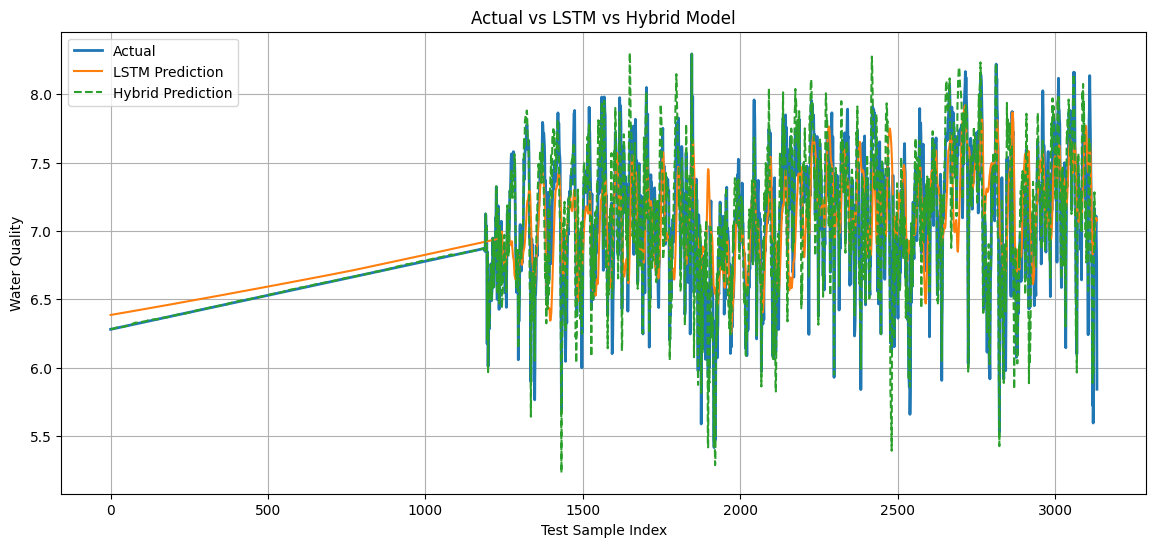

In [39]:
plt.figure(figsize=(14,6))
plt.plot(y_seq_test, label="Actual", linewidth=2)
plt.plot(y_test_pred, label="LSTM Prediction")
plt.plot(y_test_hybrid, label="Hybrid Prediction", linestyle="--")
plt.title("Actual vs LSTM vs Hybrid Model")
plt.xlabel("Test Sample Index")
plt.ylabel("Water Quality")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# ✅ Cell 14 - Anomaly Detection System

import numpy as np
import pandas as pd

# Compute absolute error between true values and hybrid predictions
error_test = np.abs(y_seq_test_adj.flatten() - y_test_hybrid.flatten())

# Dynamic anomaly threshold (mean + 3*std)
threshold = error_test.mean() + 3 * error_test.std()

# Anomaly flags
alerts = error_test > threshold

alert_df = pd.DataFrame({
    "Timestamp": pd.to_datetime(ts_seq_test[-len(error_test):]),
    "Actual_Value": y_seq_test_adj.flatten(),
    "Predicted_Value": y_test_hybrid.flatten(),
    "Error": error_test,
    "Alert": np.where(alerts, "⚠️ High Risk", "Normal")
})

print("Anomalies detected:", alerts.sum())
alert_df.head(10)


Anomalies detected: 40


,Timestamp,Actual_Value,Predicted_Value,Error,Alert
0,2024-04-22 05:30:00,6.283023,6.282744,0.000278,Normal
1,2024-04-22 06:00:00,6.283521,6.283123,0.000398,Normal
2,2024-04-22 06:30:00,6.284019,6.283669,0.000351,Normal
3,2024-04-22 07:00:00,6.284517,6.284026,0.000492,Normal
4,2024-04-22 07:30:00,6.285016,6.284404,0.000612,Normal
5,2024-04-22 08:00:00,6.285514,6.282381,0.003133,Normal
6,2024-04-22 08:30:00,6.286012,6.282759,0.003253,Normal
7,2024-04-22 09:00:00,6.286511,6.283138,0.003373,Normal
8,2024-04-22 09:30:00,6.287009,6.284139,0.002870,Normal
9,2024-04-22 10:00:00,6.287507,6.284476,0.003031,Normal


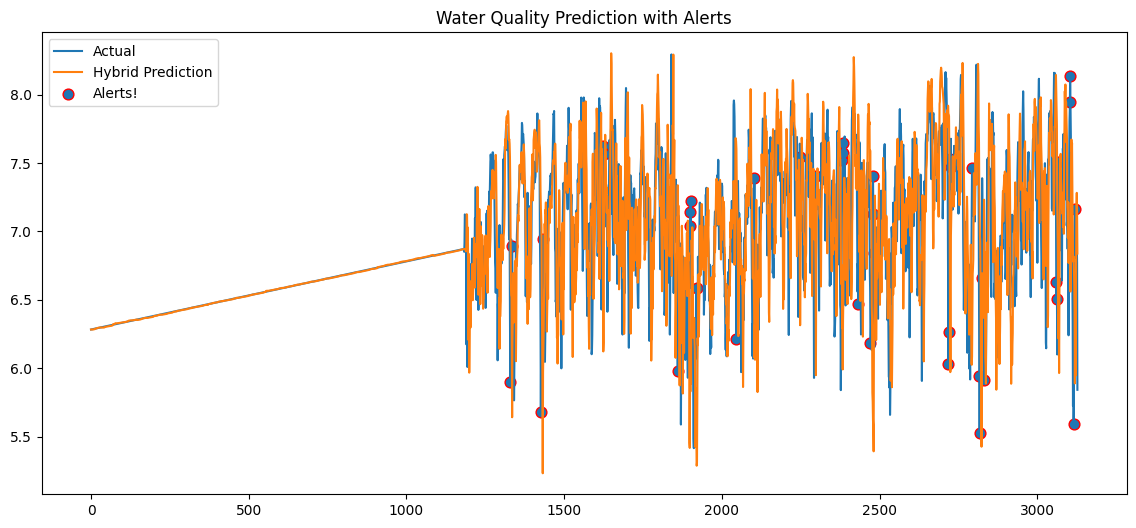

In [41]:
# ✅ Cell 15 - Plot Alerts

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_seq_test_adj, label="Actual")
plt.plot(y_test_hybrid, label="Hybrid Prediction")
plt.scatter(np.where(alerts)[0],
            y_seq_test_adj[alerts],
            marker='o', s=60,
            label="Alerts!",
            edgecolors='red')
plt.legend()
plt.title("Water Quality Prediction with Alerts")
plt.show()


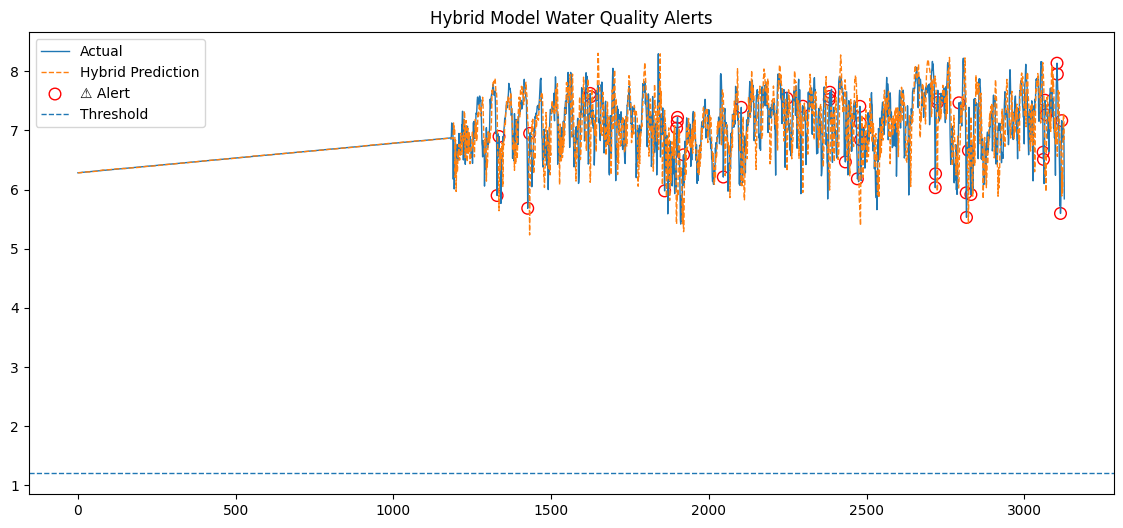

In [42]:
# ✅ Better visualization of anomalies
plt.figure(figsize=(14,6))
plt.plot(y_seq_test_adj, label="Actual", linewidth=1)
plt.plot(y_test_hybrid, label="Hybrid Prediction", linestyle='dashed', linewidth=1)

# mark alerts
alert_indices = np.where(alerts)[0]
plt.scatter(alert_indices,
            y_seq_test_adj[alerts],
            s=70, edgecolor='red',
            label="⚠️ Alert",
            facecolors='none')

plt.axhline(threshold, linestyle='--', linewidth=1, label="Threshold")
plt.title("Hybrid Model Water Quality Alerts")
plt.legend()
plt.show()


In [43]:
alert_df[alert_df["Alert"] == "⚠️ High Risk"].head(20)


,Timestamp,Actual_Value,Predicted_Value,Error,Alert
1329,2024-05-19 22:00:00,5.897667,7.353981,1.456314,⚠️ High Risk
1335,2024-05-20 01:00:00,6.896667,5.641308,1.255358,⚠️ High Risk
1426,2024-05-21 22:30:00,5.682333,7.173578,1.491244,⚠️ High Risk
1432,2024-05-22 01:30:00,6.947333,5.231550,1.715783,⚠️ High Risk
1624,2024-05-26 01:30:00,7.624667,6.122598,1.502069,⚠️ High Risk
1625,2024-05-26 02:00:00,7.568667,6.185473,1.383193,⚠️ High Risk
1860,2024-05-30 23:30:00,5.976667,7.338272,1.361605,⚠️ High Risk
1898,2024-05-31 18:30:00,7.037667,5.416944,1.620723,⚠️ High Risk
1900,2024-05-31 19:30:00,7.144667,5.828760,1.315907,⚠️ High Risk
1901,2024-05-31 20:00:00,7.219333,5.996113,1.223221,⚠️ High Risk
